**proyecto**
# Análisis de ofertas de empleo para Data Scientist
## Diplomado Ciencia de Datos - modulo II  
  
  
  
  
**Profesora: Carla Paola Malerva Reséndiz**  
**Hernández González Ricardo Paramont**  

**DataSet**:  DataScientist.csv  
    https://www.kaggle.com/andrewmvd/data-scientist-jobs  
    
**Módulo con funciones y clases personales empleadas**: modulo_hernandez_gonzalez_ricardo_paramont.py

**Escrito en latex**:

*********

In [1]:
#Importacion de bibliotecas empleadas en el notebook
#Utilidades
import pickle
import warnings
#bibliotecas para manejo de datos
import pandas as pd
import numpy as np
from random import sample
from sklearn.pipeline import Pipeline

In [2]:
#Ocultando warnings
warnings.filterwarnings('ignore')

In [3]:
#Importando modulo personal (¡DEBE ESTAR EN LA MISMA CARPETA QUE EL NOTEBOOK!)
import modulo_hernandez_gonzalez_ricardo_paramont as mine

***

***
# <p style="text-align: center;">Procesamiento de Datos</p>



***

***

### Campos de información

**Job Title**: Nombre de la oferta de trabajo.  
**Salary Estimate**: Rango del salario estimado por el portal Glassdoor, en miles de dólares representado en la notación K.  
**Job Description**: Descripción de distintos rubros de la empresa, puesto y solicitud.  
**Rating**: Calificación por parte de usuarios de la empresa en cuestion. El valor se encuentra entre 1.0 y 5.0, redondeado con un decimal.  
**Company Name**: Nombre de la compañía que ofrece la oferta de trabajo.  
**Location**: Ciudad donde se ubica el trabajo ofertado, junto con el estado o país al que pertenece.  
**Headquarters**: Ciudad y estado/país donde se ubica la sede de la empresa.  
**Size**: Divide a las empresas según su número de empleados en rangos
específicos.  
**Founded**: Año de fundación de la empresa.  
**Type of Ownership**: Tipo de compañía según razón social o identidad.  
**Industry**: Tipo de compañía según idustria en la que trabaja.  
**Sector**: Sector en la que la compañía ofrece sus bienes o servicios.  
**Revenue**: Utilidades de la compañía en dolares al año.  
**Competitors**: Principal compañía competidora de la compañía que ofrece la oferta de trabajo.
**Easy Apply**: Etiqueta que indica si la aplicación por el puesto es sencilla.  
**Salary Minimum**: Rango inferior del estimado del salario. Extraido de Salary Estimate.  
**Salary Maximum**: Rango superior del estimado del salario. Extraido de Salary Estimate.

### Importación del dataset

* Como valores ausentes, contamos con registros de tipo -1 o 'Unknown / Non-Applicable'.  

In [4]:
importar = mine.ImportDF()
df = importar.transform("DataScientist.csv")

In [5]:
pipeline_list = [('importar_df',importar)]

## Etiquetado de variables

In [6]:
etiquetar_columnas = mine.LabelColumns()
df = etiquetar_columnas.transform(df)
df.columns.to_list()

['v_job_title',
 'v_salary_estimate',
 't_job_description',
 'v_rating',
 't_company_name',
 'v_location',
 'v_headquarters',
 'v_size',
 'v_founded',
 'v_type_of_ownership',
 'v_industry',
 'v_sector',
 'v_revenue',
 'v_competitors',
 'v_easy_apply']

In [7]:
pipeline_list.append(('etiquetar_columnas',etiquetar_columnas))

## Completitud

In [8]:
mine.completitud(df)

,columna,total,completitud
0,v_easy_apply,3745,4.195
1,v_competitors,2760,29.394
2,v_revenue,1392,64.390
3,v_founded,977,75.006
4,v_industry,546,86.032
5,v_sector,546,86.032
6,v_rating,409,89.537
7,v_headquarters,240,93.860
8,v_size,229,94.142
9,v_type_of_ownership,229,94.142


Eliminando unicamente v_easy_apply
Las demás columnas con menos de 80% de completitud serán transformadas mas adelante

In [9]:
eliminar_columnas_incompletas = mine.DeleteColumns(columns=['v_easy_apply'])
df = eliminar_columnas_incompletas.transform(df)

In [10]:
pipeline_list.append(('eliminar_columnas_incompletas',eliminar_columnas_incompletas))

## Limpieza de Texto
Se eliminan caracteres especiales y se cambian mayúsculas por minúsculas.

In [11]:
limpiar_texto = mine.CleanText()
df = limpiar_texto.transform(df)

In [12]:
pipeline_list.append(('limpiar_texto',limpiar_texto))

# Conceptualización del problema: 
### Tratamiento de la variable target (salario estimado)
  
<br>
<br>
Originalmente, el problema se había pensado para un problema de regresión donde se estimaba un valor puntual del salario de la oferta de empleo. Sin embargo, la calidad y cantidad de información complican bastante el poder obtener un modelo con buenas métricas para este objetivo.
Por esto mismo, se decidió replantear el objetivo del proyecto como uno de clasificación, que estimaría el salario del puesto dentro de rangos, o categorías.

Primero, para definir las categorías de la clase, se normalizará la columna tomando el promedio entre su estimación mínima y máxima.

In [13]:
transformar_salario = mine.GetSalaryMean()
df = transformar_salario.transform(df)
df['v_salary_estimate'].describe()

count      3909.000000
mean     108034.879509
std       38388.902493
min       37584.000000
25%       75000.000000
50%      104500.000000
75%      133000.000000
max      225000.000000
Name: v_salary_estimate, dtype: float64

In [14]:
df['v_salary_estimate'].quantile([0.33,0.66])

0.33     84500.0
0.66    124640.0
Name: v_salary_estimate, dtype: float64

Se decide dividir el salario en **tres categorias**: <br> 
1.- menor de 85K anuales - categoría **0**  
2.- mayor a 85k y menor a125k anuales - categoria **1**  
3.- 125k o más anuales - categoria **2**
<br>

In [15]:
categorizar_salario = mine.CategorizeSalary()
df = categorizar_salario.transform(df)
df['v_salary_estimate'].value_counts()

2    1329
0    1318
1    1262
Name: v_salary_estimate, dtype: int64

In [16]:
pipeline_list.extend([('transformar_salario',transformar_salario),
                      ('categorizar_salario',categorizar_salario)])
pipeline = Pipeline(pipeline_list)

# Normalización

### Normalizando v_job_title

Antes de normalizar la columna, se intentará extraer información que indique si el puesto es de un alto rango.
Se incluye la columna dummy **v_is_high_rank** que indica si el título del trabajo contiene alguna de las palabras:
* senior
* manager
* chief
* supervisor
* director
* executive
* boss
* officer
* specialist
* lead
* principal

In [17]:
rango_alto = mine.HighRank()
df = rango_alto.transform(df)

In [18]:
pipeline_list.append(('rango_alto',rango_alto))

**Normalizando de tal forma que las únicas categorías sean:**  
- data scientist: cualquier titulo que contanga ambas palabras  
- data analyst: cualquier titulo que contanga ambas palabras  
- data engineer: cualquier titulo que contanga ambas palabras  
- specific discipline scientist: cualquier titulo que contanga la palabra scientist en él, sin contener la palabra data.  
- machine learning professional: cualquier titulo que contanga las palabras machine learning.  
- businesss intelligence analyst: cualquier empleo que contenga las palabras business intelligence.  
- analyst of other nature: cualquier empleo que contenga la palabra analyst sin, sin contener las palabras data o business.
- highly specific: todos los títulos con una sola ocurrencia que no fueron agrupados en las anteriores categorías.
- others: categorías restantes que en conjunto, siguen consistiendo en la categoría de menor frecuencia.

In [19]:
normalizar_job_title = mine.NormalizeJobTitle()
df =normalizar_job_title.transform(df)
df['v_job_title'].unique()

array(['data scientist', 'data analyst', 'others',
       'specific discipline scientist', 'data engineer',
       'analyst of other nature', 'highly specific',
       'machine learning professional', 'business intelligence analyst'],
      dtype=object)

In [20]:
pipeline_list.append(('normalizar_job_title',normalizar_job_title))

### Normalizando location
Se separa la columna en sus valores de ciudad (v_city) y estado (v_state).

In [21]:
normalizar_location = mine.NormalizeLocation('v_location')
df = normalizar_location.transform(df)

In [22]:
pipeline_list.append(('normalizar_location',normalizar_location))

### Normalizando Headquarters
Se separa igualmente en ciudad (v_headquarters_city) y estado (v_headquarters_state).

In [23]:
normalizar_headquarters = mine.NormalizeLocation(location='v_headquarters',prefix=True)
df = normalizar_headquarters.transform(df)

In [24]:
pipeline_list.append(('normalizar_headquarters',normalizar_headquarters))

### Normalizando v_industry, v_type_of_ownership
* industry: se agrupan las clases que tienen menos de 9 ocurrencias dentro de la clase 'others'.
* type of ownership: se agrupan las clases que tienen menos de 5 ocurrencias dentro de la clase 'others'.

In [25]:
normalizar_industry = mine.NormalizeToOthers([('v_industry',9), ('v_type_of_ownership',5)])
df = normalizar_industry.transform(df)

In [26]:
pipeline_list.append(('normalizar_industry',normalizar_industry))

# División de train y test
80% de los datos serán de entrenamiento, 20% para prueba.

In [27]:
from sklearn.model_selection import train_test_split
X = df.drop(columns='v_salary_estimate')
y = df['v_salary_estimate']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=0, stratify=y)

# Valores Ausentes

In [28]:
mine.completitud(X_train)

,columna,total,completitud
0,v_competitors,2213,29.229
1,v_revenue,1090,65.142
2,v_founded,777,75.152
3,v_industry,427,86.345
4,v_sector,427,86.345
5,v_rating,320,89.767
6,v_headquarters_state,197,93.700
7,v_headquarters_city,195,93.764
8,v_size,184,94.116
9,v_type_of_ownership,184,94.116


##### Se imputará con la siguiente estratégia:
* mediana para v_rating
* moda para categoricas con más de 80% de completitud
* mediana v_founded
* la variable v_competitors se transfomará a columna dummy que indica si existe un valor o no y otra columna que indica el número de competidores en dicho registro
* para la variable v_revenue se hará ordinal encoding en la parte de ingeniería de variables.

##### v_rating

In [29]:
imputar_rating = mine.mySimpleImputer(['v_rating'],'median')
imputar_rating.fit(X_train)
X_train = imputar_rating.transform(X_train)
X_test = imputar_rating.transform(X_test)

In [30]:
pipeline_list.append(('imputar_rating',imputar_rating))

##### categóricas con completitud mayor a 80%

In [31]:
categoricas_incompletas = ['v_type_of_ownership','v_size','v_headquarters_city','v_headquarters_state','v_sector','v_industry']
imputar_categoricas = mine.mySimpleImputer(categoricas_incompletas,'most_frequent')
imputar_categoricas.fit(X_train)
X_train = imputar_categoricas.transform(X_train)
X_test = imputar_categoricas.transform(X_test)

In [32]:
pipeline_list.append(('imputar_categoricas',imputar_categoricas))

##### v_founded

In [33]:
imputar_founded = mine.mySimpleImputer(['v_founded'],'median')
imputar_founded.fit(X_train)
X_train = imputar_founded.transform(X_train)
X_test = imputar_founded.transform(X_test)

In [34]:
pipeline_list.append(('imputar_founded',imputar_founded))

#### v_competitors

In [35]:
competitors_transformer = mine.CompetitorsTransformer('v_competitors')
X_train = competitors_transformer.transform(X_train)
X_test = competitors_transformer.transform(X_test)
X_train[['v_competitors','v_competitors_count']].head()

,v_competitors,v_competitors_count
1040,0,0.0
306,0,0.0
415,0,0.0
2083,1,3.0
2556,1,3.0


In [36]:
pipeline_list.append(('competitors_transformer',competitors_transformer))

In [37]:
mine.completitud(X_train)

,columna,total,completitud
0,v_revenue,1090,65.142
1,v_job_title,0,100.000
2,v_headquarters_city,0,100.000
3,v_state,0,100.000
4,v_city,0,100.000
5,v_is_high_rank,0,100.000
6,v_competitors,0,100.000
7,v_headquarters_state,0,100.000
8,v_sector,0,100.000
9,v_type_of_ownership,0,100.000


In [38]:
mine.completitud(X_test)

,columna,total,completitud
0,v_revenue,302,61.381
1,v_job_title,0,100.000
2,v_headquarters_city,0,100.000
3,v_state,0,100.000
4,v_city,0,100.000
5,v_is_high_rank,0,100.000
6,v_competitors,0,100.000
7,v_headquarters_state,0,100.000
8,v_sector,0,100.000
9,v_type_of_ownership,0,100.000


# Ingenieria de Variables

#### v_big_city
Variable dummy que indica si el registro se encuentra entre las 20 ciudades más pobladas de Estados Unidos:
* 'New York'
* 'Los Angeles'
* 'Chicago'
* 'Houston'
* 'Phoenix',
* 'Philadelphia' 
* 'San Antonio'
* 'San Diego'
* 'Dallas'
* 'San Jose'
* 'Austin'
* 'Jacksonville'
* 'Fort Worth'
* 'Columbus'
* 'Charlotte'
* 'San Francisco'
* 'Indianapolis'
* 'Seattle'
* 'Denver'
* 'Washington'

In [39]:
big_city = mine.BigCity('v_city')
X_train = big_city.transform(X_train)
X_test = big_city.transform(X_test)

In [40]:
pipeline_list.append(('big_city',big_city))

#### v_is_bigtech
Se incluye una columna que revisará si la compañia (t_company_name) está dentro de las empresas FAANG o Big Tech. Se consideran las empresas:
* facebook
* amazon
* apple
* netflix
* google
* microsoft
* ibm
* spotify
* tesla
* uber
* twitter
* alphabet
* visa
* nvidia
* intel
* adobe
* cisco
* at&t
* oracle
* airbnb
* samsung
* foxconn
* huawei
* dell
* sony
* hp
* lg
* lenovo


In [41]:
big_tech = mine.BigTech()
X_train = big_tech.transform(X_train)
X_test = big_tech.transform(X_test)

In [42]:
pipeline_list.append(('big_tech',big_tech))

## Categoricas

### One-Hot encoding / Dummies
Para codificación de variables categóricas sin orden. Crea columnas dummy.

In [43]:
categorical_to_dummify = ['v_job_title','v_type_of_ownership','v_industry','v_sector',
                          'v_city','v_state','v_headquarters_city','v_headquarters_state',]
get_dummies = mine.myOneHotEncoder(columns=categorical_to_dummify)
get_dummies.fit(X_train)
X_train = get_dummies.transform(X_train)
X_test = get_dummies.transform(X_test)

In [44]:
pipeline_list.append(('get_dummies',get_dummies))

### Ordinal encoding
Codificación de categoricas con orden en sus clases. El orden se especifica en las siguientes listas, el primer elemento recibe el valor 0.

In [45]:
size_order = ['unknown',
              '1 to 50 employees',
              '51 to 200 employees',
              '201 to 500 employees',
              '501 to 1000 employees',
              '1001 to 5000 employees',
              '5001 to 10000 employees',
              '10000 employees'
             ]
revenue_order = ['unknown',
                 'Less than $1 million (USD)',
                 '$1 to $5 million (USD)',
                 '$5 to $10 million (USD)',
                 '$10 to $25 million (USD)',
                 '$25 to $50 million (USD)',
                 '$50 to $100 million (USD)',
                 '$100 to $500 million (USD)',
                 '$500 million to $1 billion (USD)',
                 '$1 to $2 billion (USD)',
                 '$2 to $5 billion (USD)',
                 '$5 to $10 billion (USD)',
                 '$10+ billion (USD)', 
                ]

In [46]:
ordinal_encoding = mine.myOrdinalEncoder(columns=['v_size','v_revenue'],categories=[size_order,revenue_order])
ordinal_encoding.fit(X_train)
X_train = ordinal_encoding.transform(X_train)
X_test = ordinal_encoding.transform(X_test)

In [47]:
pipeline_list.append(('ordinal_encoding',ordinal_encoding))

## Texto 

### Longitud en chars y palabras
Crea columnas adicionales para las variables de texto indicadas. Las columnas tienen el valor de la longitud del texto según número de caracteres y número de palabras.

In [48]:
longitud_texto = mine.TextLength(columns=['t_job_description','t_company_name'])
X_train = longitud_texto.transform(X_train)
X_test = longitud_texto.transform(X_test)

In [49]:
pipeline_list.append(('longitud_texto',longitud_texto))

### Vectorización

#### Eliminación de stopwords

In [50]:
borrar_stop_words = mine.DeleteStopwords(column='t_job_description')
X_train = borrar_stop_words.transform(X_train)
X_test = borrar_stop_words.transform(X_test)

In [51]:
pipeline_list.append(('borrar_stop_words',borrar_stop_words))

#### Count Vectorizer

In [52]:
#Vectorizacion para palabras que aparecen al menos 5.0% de las veces (min_df=0.05)
vectorizer = mine.MyCountVectorizer(column='t_job_description', min_df=0.05)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [53]:
pipeline_list.append(('vectorizer',vectorizer))

#### Eliminando columnas extra

In [54]:
#Se elimina compay name, porque no será vectorizada
borrar_columnas = mine.DeleteColumns(columns='t_company_name')
X_train = borrar_columnas.transform(X_train)
X_test = borrar_columnas.transform(X_test)

## Reducción de dimensiones 

#### Filtro de baja correlación con el objetivo

El filtro se aplicará a las columnas resultado de one hot encoding o count vectorizer.

In [55]:
correlation = abs(X_train.filter(regex='x\d_|vect_').corrwith(y_train, method='spearman'))
low_corr = correlation[correlation<0.001].reset_index().sort_values(by=0)
low_corr

,index,0
198,vect_driven,7.812240e-07
218,vect_predictive,2.199258e-05
225,vect_think,2.834936e-05
193,vect_complete,3.844452e-05
220,vect_proud,5.595485e-05
...,...,...
39,x4_santa monica,8.429812e-04
5,x3_consumer services,8.538389e-04
6,x3_nonprofit,8.772268e-04
190,vect_attention,9.091458e-04


#### Filtro de Multicolinealidad

Se encontró el _variance inflation factor_ (vif) de las columnas correspondientes a las variables generadas por one hot encoding y count vectorizing, y se guardaron dihcos valores como un dataframe en un archivo pickle que se carga en el presente código. Esto con el motivo de no tener que hacer los cálculos con cada corrida del notebook.
El código correspondiente al cálculo del vif se sigue mostrando, pero en celdas desactivadas.

Revisando primero para variables generadas por **one hot encoding**

In [56]:
#Carga del dataframe generado con anterioridad
with open('vif_encoding.pkl','rb') as f:
    vif_encoding = pickle.load(f)
high_vif = vif_encoding[vif_encoding['VIF']>10]
high_vif

,variables,VIF
7,x1_company - private,34.432554
8,x1_company - public,19.375766
16,x2_aerospace defense,inf
18,x2_biotech pharmaceuticals,inf
31,x2_health care services hospitals,inf
...,...,...
573,x7_united kingdom,10.865061
576,x7_va,10.807300
577,x7_vietnam,inf
578,x7_vt,inf


Ahora para variables generadas por **count vectorizing**

In [57]:
#Carga de dataframe generado con anterioridad
with open('vif_vectorizing.pkl','rb') as f:
    vif_vectorizing = pickle.load(f)
high_vif2 = vif_vectorizing[vif_vectorizing['VIF']>10]
high_vif2

,variables,VIF
88,vect_color,19.286125
128,vect_data,11.594618
218,vect_gender,12.546754
284,vect_learning,12.274222
299,vect_machine,10.671514
415,vect_race,30.095987


##### Eliminando columnas que no pasaron filtros

In [58]:
#lostado de variables que no pasaron el filtro
filtered_columns = pd.concat([ low_corr['index'],high_vif2['variables'],high_vif2['variables'] ],  axis=0 )
filtered_columns

198        vect_driven
218    vect_predictive
225         vect_think
193      vect_complete
220         vect_proud
            ...       
128          vect_data
218        vect_gender
284      vect_learning
299       vect_machine
415          vect_race
Length: 240, dtype: object

In [59]:
np.append(filtered_columns.values,'t_company_name')[:5]

array(['vect_driven', 'vect_predictive', 'vect_think', 'vect_complete',
       'vect_proud'], dtype=object)

In [60]:
borrar_columnas = mine.DeleteColumns(columns=filtered_columns)
X_train = borrar_columnas.transform(X_train)
X_test = borrar_columnas.transform(X_test)

In [61]:
#Annadiendo paso de borrado de columnas al pipeline, jutno con el borrado de company name y el objetivo
delete_list = np.append(filtered_columns.values,['t_company_name','v_salary_estimate'])
borrar_columnas = mine.DeleteColumns(columns=delete_list) 
pipeline_list.append(('borrar_columnas',borrar_columnas))
#Creando pipeline
pipeline = Pipeline(pipeline_list)
#Revisando dataframe generado por el pipeline
pipeline.transform("DataScientist.csv").head()

,v_rating,v_founded,v_competitors,v_is_high_rank,v_competitors_count,v_big_city,v_is_big_tech,x0_analyst of other nature,x0_business intelligence analyst,x0_data analyst,...,vect_worlds,vect_would,vect_write,vect_writing,vect_written,vect_year,vect_years,vect_york,vect_youll,vect_youre
0,3.5,2007.0,0,1,0.0,1,0,0.0,0.0,0.0,...,2,1,0,0,0,0,1,0,0,0
1,4.5,2008.0,0,0,0.0,1,0,0.0,0.0,0.0,...,0,0,1,1,0,0,1,0,2,0
2,3.8,1996.0,0,1,0.0,1,0,0.0,0.0,0.0,...,0,0,0,0,0,0,2,2,1,0
3,3.4,2019.0,1,0,2.0,0,0,0.0,0.0,1.0,...,0,0,0,0,1,0,2,0,1,0
4,3.4,2007.0,1,1,3.0,1,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


### Revisando dataset antes del modelado

In [62]:
print(X_train.shape)
print(X_test.shape)

(3127, 1524)
(782, 1524)


In [63]:
#Revisando tipos de datos para categoricas base
X_train.filter(like='v_').dtypes

v_rating               float64
v_founded              float64
v_competitors            int64
v_is_high_rank           int64
v_competitors_count    float64
v_big_city               int64
v_is_big_tech            int64
v_size                 float64
v_revenue              float64
dtype: object

In [64]:
#Solo hay ints y floats en los tipos de las columnas:
np.unique(X_train.dtypes.values)

array([dtype('int64'), dtype('float64')], dtype=object)

In [65]:
#revisando si el pipeline da las mismas columnas que nuestro dataset
X_pipe = pipeline.transform("DataScientist.csv").head()
print(X_pipe.shape)
set(X_train.columns) - set(X_pipe.columns)

(5, 1524)


set()

In [66]:
X_train['v_revenue']

0        3.0
1        2.0
2        0.0
3        8.0
4       12.0
        ... 
3122     0.0
3123    12.0
3124     4.0
3125     0.0
3126     0.0
Name: v_revenue, Length: 3127, dtype: float64

#### Parametros de train y test

In [67]:
print('Proporción de train: ', len(y_train)/len(df))
print('Proporción de test: ', len(y_test)/len(df))

Proporción de train:  0.7999488360194423
Proporción de test:  0.2000511639805577


In [68]:
len(y_test)

782

In [69]:
y_test.value_counts(1)

2    0.340153
0    0.337596
1    0.322251
Name: v_salary_estimate, dtype: float64

***

***
# <p style="text-align: center;">Modelado</p>



***

***

Todos los modelos probados fueron guardados como archivos pickle para poder visualizar sus métricas sin tener que reentrenar. Las celdas de entrenamiento y guardado de modelos se siguen mostando, pero están desactivadas. Para activarlas, se presiona Esc+Y sobre la celda, para desactivarlas se presiona Esc+R sobre la celda.

### Escalado
Se encuentra que el escalado mejora el desempeño de algunos modelos (además de ser obligatorio para algunos como knn)

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
std_scal=StandardScaler()
std_scal.fit(X_train,y_train)
pipeline_list.append(('escalado_estandar',std_scal))
pipeline = Pipeline(pipeline_list)

In [72]:
X_train=std_scal.transform(X_train)
X_test=std_scal.transform(X_test)

## KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier

In [74]:
knn=KNeighborsClassifier()

param_grid = dict(n_neighbors = range(5,100))

 Métricas Train 
              precision    recall  f1-score   support

           0      0.548     0.635     0.588      1054
           1      0.459     0.625     0.529      1010
           2      0.721     0.359     0.480      1063

    accuracy                          0.538      3127
   macro avg      0.576     0.540     0.532      3127
weighted avg      0.578     0.538     0.532      3127



 Métricas Test 
              precision    recall  f1-score   support

           0      0.523     0.598     0.558       264
           1      0.409     0.544     0.467       252
           2      0.717     0.391     0.506       266

    accuracy                          0.510       782
   macro avg      0.550     0.511     0.510       782
weighted avg      0.552     0.510     0.511       782



 Matríz de confusión de Train 


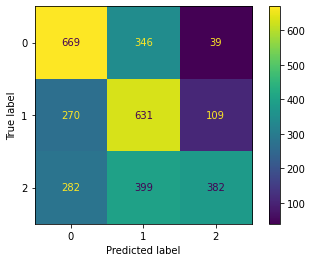

 Matríz de confusión de Test 


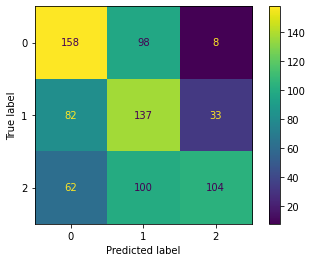

 ROC train 


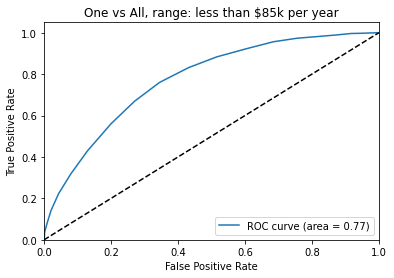

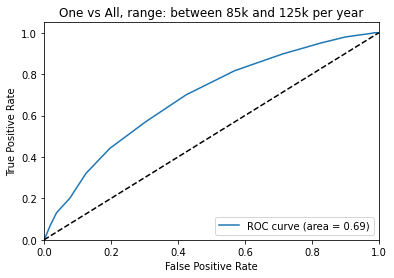

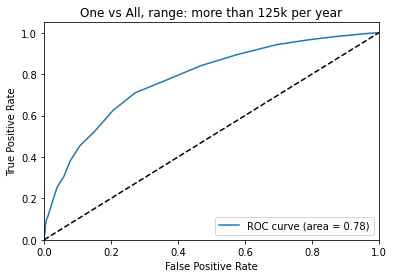

 ROC test 


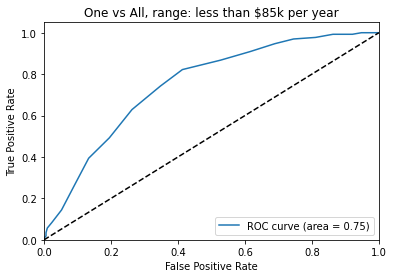

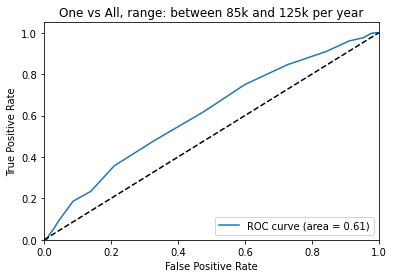

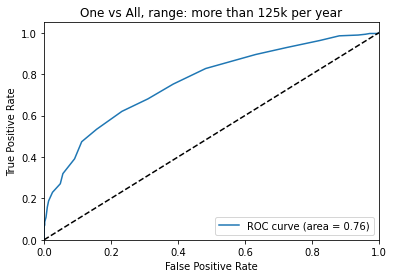

In [75]:
if 'best_knn' not in locals():
    with open('best_knn.pkl','rb') as f:
        best_knn = pickle.load(f)
mine.metrics_master_multiclass(X_train, y_train, X_test, y_test, best_knn)

## Regresión Logistica

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
log_reg= LogisticRegression()

param_grid = dict(penalty=["l2","l1","elasticnet"],
                  solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                  random_state=[0]
                 )

 Métricas Train 
              precision    recall  f1-score   support

           0      0.899     0.925     0.912      1054
           1      0.879     0.880     0.880      1010
           2      0.933     0.905     0.919      1063

    accuracy                          0.904      3127
   macro avg      0.904     0.903     0.903      3127
weighted avg      0.904     0.904     0.904      3127



 Métricas Test 
              precision    recall  f1-score   support

           0      0.533     0.519     0.526       264
           1      0.422     0.429     0.425       252
           2      0.550     0.556     0.553       266

    accuracy                          0.503       782
   macro avg      0.502     0.501     0.501       782
weighted avg      0.503     0.503     0.503       782



 Matríz de confusión de Train 


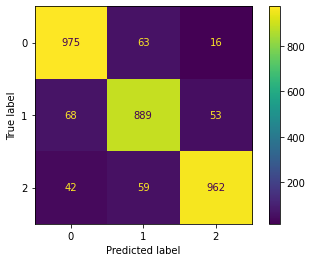

 Matríz de confusión de Test 


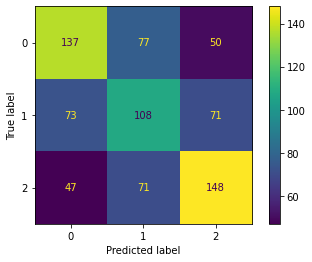

 ROC train 


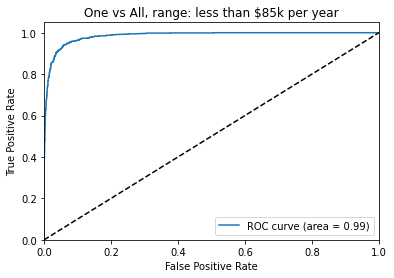

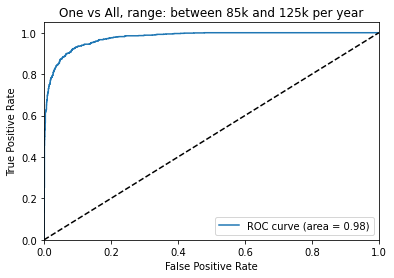

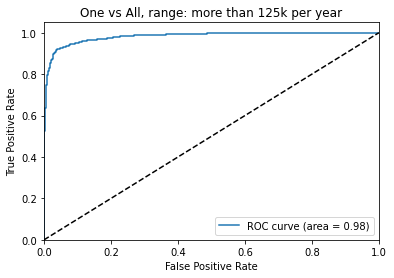

 ROC test 


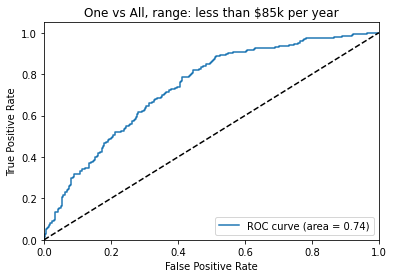

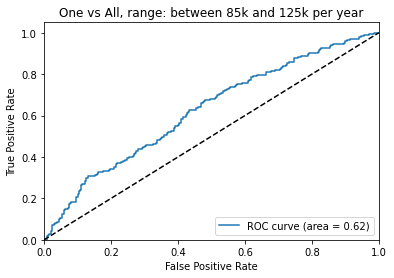

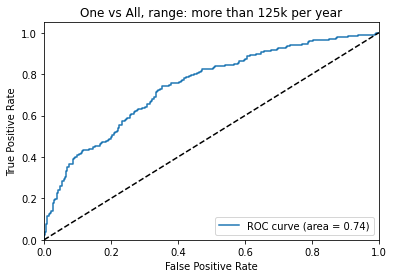

In [78]:
if 'best_log' not in locals():
    with open('best_log.pkl','rb') as f:
        best_log = pickle.load(f)
mine.metrics_master_multiclass(X_train, y_train, X_test, y_test, best_log)

El modelo presenta sobreajuste claramente.

## SVC

In [79]:
from sklearn.svm import SVC

In [80]:
svc = SVC(random_state = 0,probability=True)

param_grid = dict(kernel=['poly', 'rbf', 'sigmoid'])

 Métricas Train 
              precision    recall  f1-score   support

           0      0.649     0.755     0.698      1054
           1      0.628     0.566     0.596      1010
           2      0.735     0.685     0.709      1063

    accuracy                          0.670      3127
   macro avg      0.671     0.669     0.668      3127
weighted avg      0.672     0.670     0.669      3127



 Métricas Test 
              precision    recall  f1-score   support

           0      0.547     0.591     0.568       264
           1      0.436     0.444     0.440       252
           2      0.646     0.583     0.613       266

    accuracy                          0.541       782
   macro avg      0.543     0.539     0.540       782
weighted avg      0.545     0.541     0.542       782



 Matríz de confusión de Train 


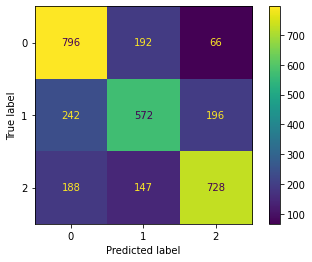

 Matríz de confusión de Test 


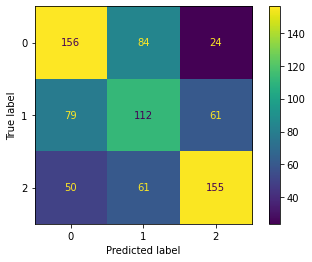

 ROC train 


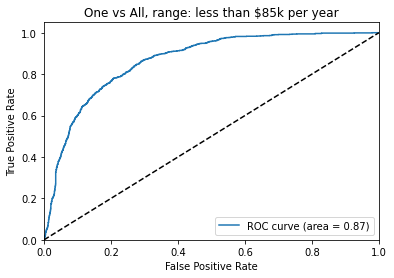

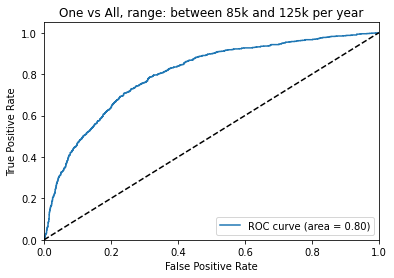

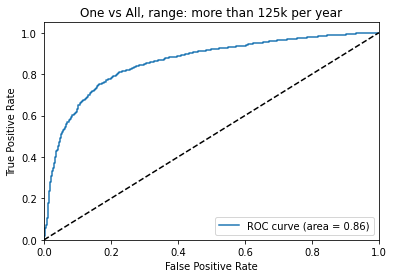

 ROC test 


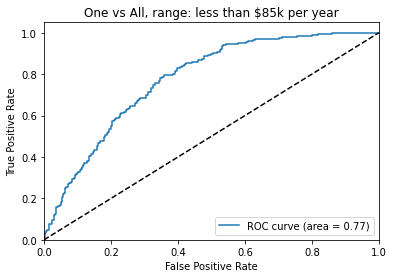

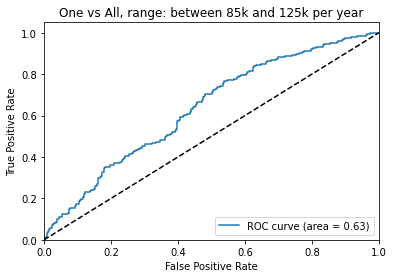

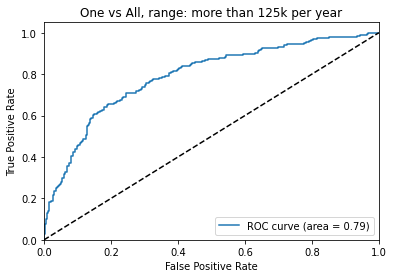

In [81]:
if 'best_svc' not in locals():
    with open('best_svc.pkl','rb') as f:
        best_svc = pickle.load(f)
mine.metrics_master_multiclass(X_train, y_train, X_test, y_test, best_svc)

## Árboles de decisión

In [82]:
from sklearn.tree import DecisionTreeClassifier

In [83]:
tree = DecisionTreeClassifier()

param_grid = dict(criterion = ["gini", "entropy"],
                 max_depth=list(range(2,8)))

 Métricas Train 
              precision    recall  f1-score   support

           0      0.527     0.868     0.656      1054
           1      0.551     0.287     0.378      1010
           2      0.719     0.585     0.645      1063

    accuracy                          0.584      3127
   macro avg      0.599     0.580     0.560      3127
weighted avg      0.600     0.584     0.562      3127



 Métricas Test 
              precision    recall  f1-score   support

           0      0.564     0.856     0.680       264
           1      0.523     0.313     0.392       252
           2      0.709     0.613     0.657       266

    accuracy                          0.598       782
   macro avg      0.598     0.594     0.576       782
weighted avg      0.600     0.598     0.579       782



 Matríz de confusión de Train 


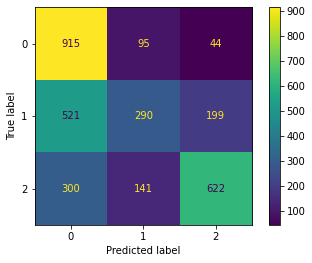

 Matríz de confusión de Test 


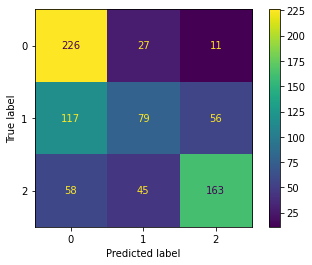

 ROC train 


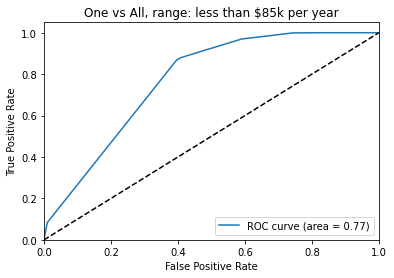

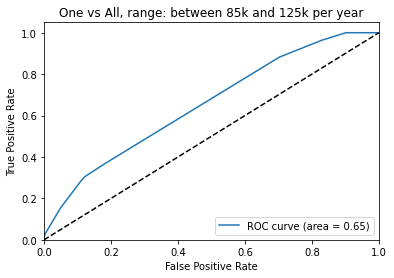

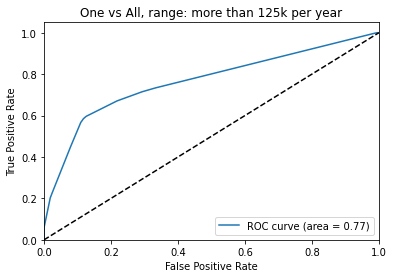

 ROC test 


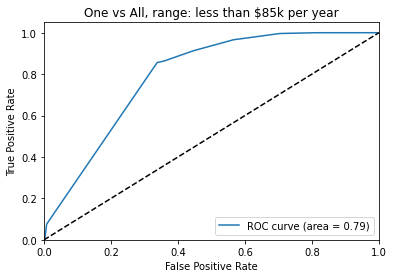

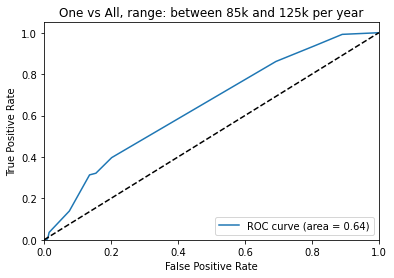

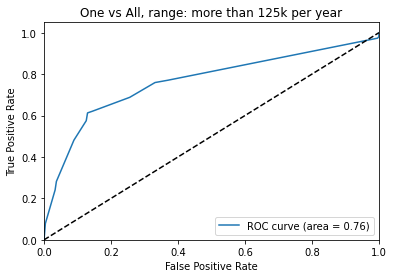

In [84]:
if 'best_tree' not in locals():
    with open('best_tree.pkl','rb') as f:
        best_tree = pickle.load(f)
mine.metrics_master_multiclass(X_train, y_train, X_test, y_test, best_tree)

## Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [86]:
random_f= RandomForestClassifier()

param_grid = dict(n_estimators=range(50,101,10),
                  max_depth=[1,2,3,4,5,None],
                  criterion=["gini", "entropy"],
                  bootstrap=[True,False],
                  oob_score=[True,False],
                  random_state=[0]
                 )

 Métricas Train 
              precision    recall  f1-score   support

           0      0.578     0.860     0.691      1054
           1      0.803     0.275     0.410      1010
           2      0.665     0.759     0.709      1063

    accuracy                          0.637      3127
   macro avg      0.682     0.631     0.603      3127
weighted avg      0.680     0.637     0.606      3127



 Métricas Test 
              precision    recall  f1-score   support

           0      0.538     0.780     0.637       264
           1      0.500     0.175     0.259       252
           2      0.614     0.718     0.662       266

    accuracy                          0.564       782
   macro avg      0.551     0.558     0.519       782
weighted avg      0.552     0.564     0.524       782



 Matríz de confusión de Train 


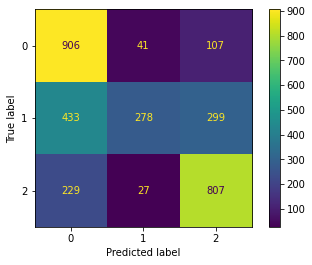

 Matríz de confusión de Test 


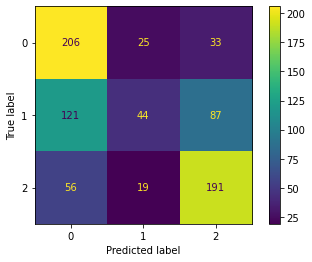

 ROC train 


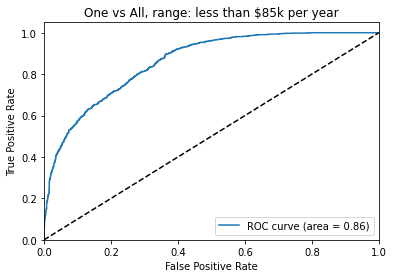

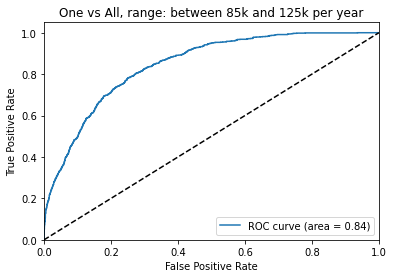

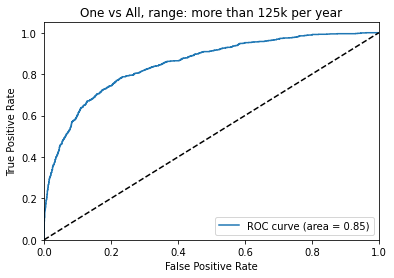

 ROC test 


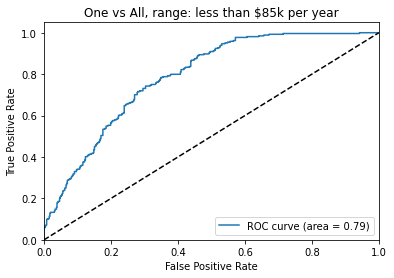

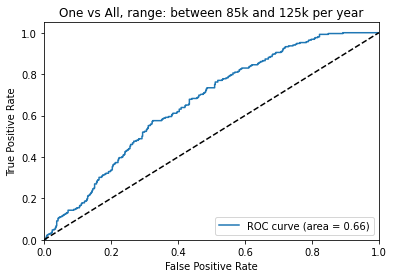

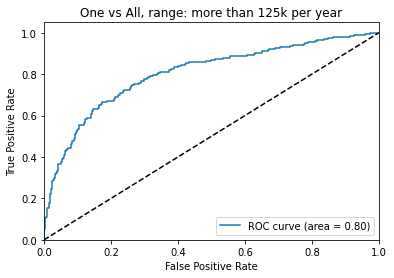

In [87]:
if 'best_random_f' not in locals():
    with open('best_random_f.pkl','rb') as f:
        best_random_f = pickle.load(f)
mine.metrics_master_multiclass(X_train, y_train, X_test, y_test, best_random_f)

## Gradiente estcástico descendente

In [88]:
from sklearn.linear_model import SGDClassifier

In [89]:
sgd = SGDClassifier()

param_grid = dict(loss = ["log"],
                 penalty=["l2","l1","elasticnet"],
                 alpha=np.arange(0.00001,.3,.001))

 Métricas Train 
              precision    recall  f1-score   support

           0      0.588     0.775     0.669      1054
           1      0.579     0.415     0.483      1010
           2      0.688     0.656     0.671      1063

    accuracy                          0.618      3127
   macro avg      0.618     0.615     0.608      3127
weighted avg      0.619     0.618     0.610      3127



 Métricas Test 
              precision    recall  f1-score   support

           0      0.600     0.750     0.667       264
           1      0.552     0.440     0.490       252
           2      0.677     0.639     0.658       266

    accuracy                          0.613       782
   macro avg      0.610     0.610     0.605       782
weighted avg      0.611     0.613     0.607       782



 Matríz de confusión de Train 


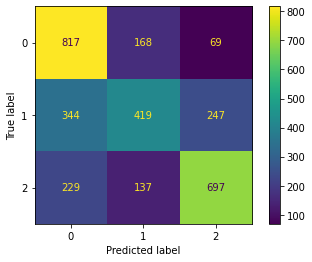

 Matríz de confusión de Test 


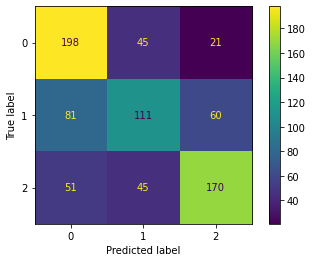

 ROC train 


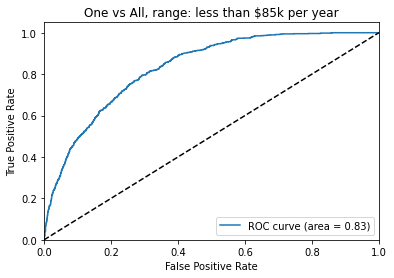

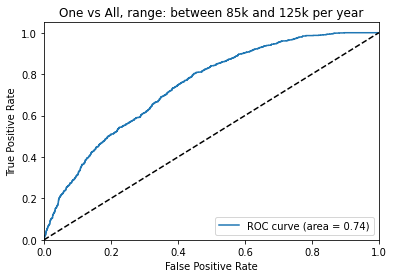

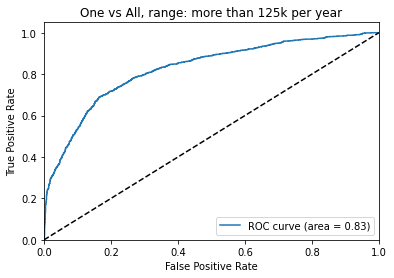

 ROC test 


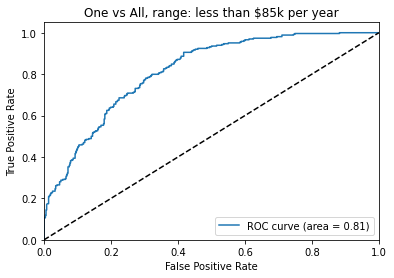

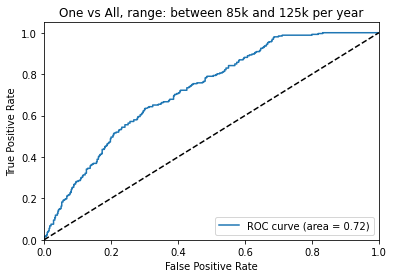

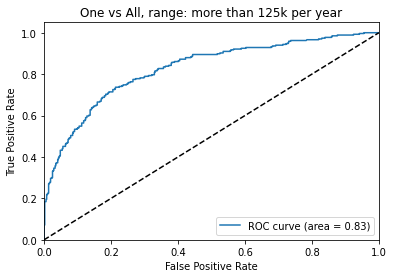

In [90]:
if 'best_sgd' not in locals():
    with open('best_sgd.pkl','rb') as f:
        best_sgd = pickle.load(f)
mine.metrics_master_multiclass(X_train, y_train, X_test, y_test, best_sgd)

## Gradient Boost

In [91]:
from sklearn.ensemble import GradientBoostingClassifier

 Métricas Train 
              precision    recall  f1-score   support

           0      0.743     0.853     0.794      1054
           1      0.757     0.661     0.706      1010
           2      0.803     0.782     0.792      1063

    accuracy                          0.767      3127
   macro avg      0.768     0.765     0.764      3127
weighted avg      0.768     0.767     0.765      3127



 Métricas Test 
              precision    recall  f1-score   support

           0      0.595     0.674     0.632       264
           1      0.509     0.460     0.483       252
           2      0.678     0.650     0.664       266

    accuracy                          0.597       782
   macro avg      0.594     0.595     0.593       782
weighted avg      0.596     0.597     0.595       782



 Matríz de confusión de Train 


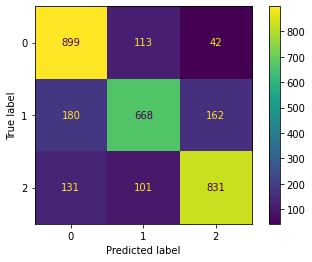

 Matríz de confusión de Test 


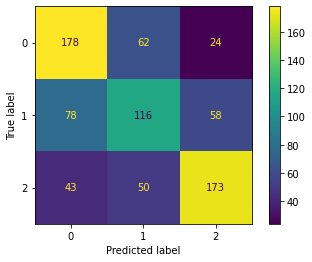

 ROC train 


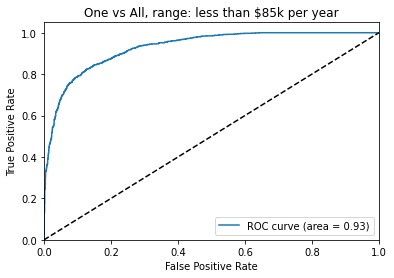

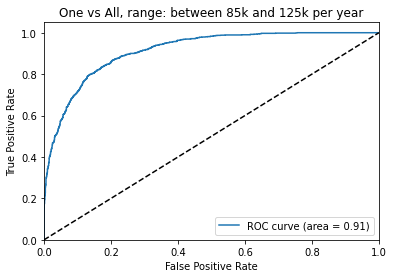

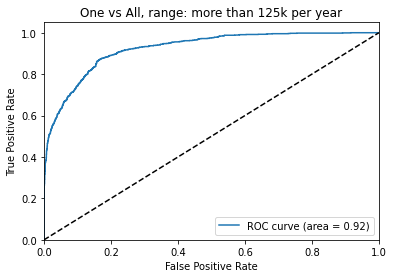

 ROC test 


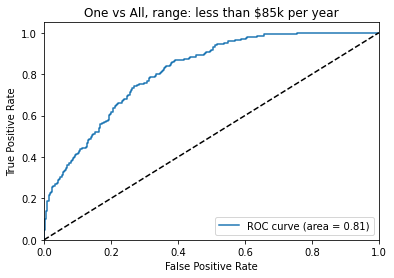

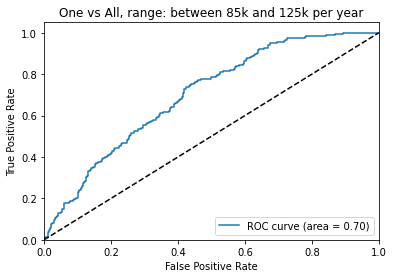

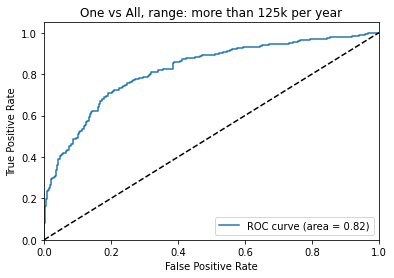

In [92]:
if 'best_gb' not in locals():
    with open('best_gb.pkl','rb') as f:
        best_gb = pickle.load(f)
mine.metrics_master_multiclass(X_train, y_train, X_test, y_test, best_gb)

## Ada Boost

In [93]:
from sklearn.ensemble import AdaBoostClassifier

In [94]:
ada=AdaBoostClassifier()

param_grid={"n_estimators":range(50,200,10),
            "learning_rate":np.arange(0.1,2,.3),
            "random_state":[0]
           }

 Métricas Train 
              precision    recall  f1-score   support

           0      0.564     0.779     0.654      1054
           1      0.487     0.449     0.467      1010
           2      0.714     0.499     0.587      1063

    accuracy                          0.577      3127
   macro avg      0.589     0.575     0.570      3127
weighted avg      0.590     0.577     0.571      3127



 Métricas Test 
              precision    recall  f1-score   support

           0      0.575     0.739     0.647       264
           1      0.480     0.468     0.474       252
           2      0.716     0.530     0.609       266

    accuracy                          0.581       782
   macro avg      0.590     0.579     0.577       782
weighted avg      0.592     0.581     0.578       782



 Matríz de confusión de Train 


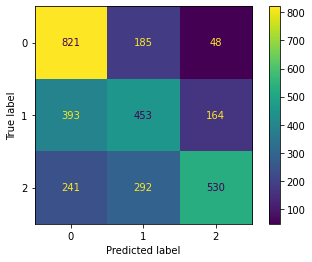

 Matríz de confusión de Test 


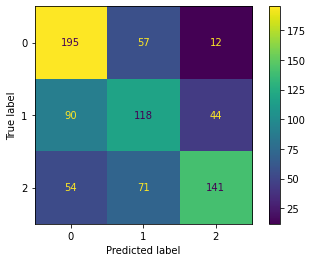

 ROC train 


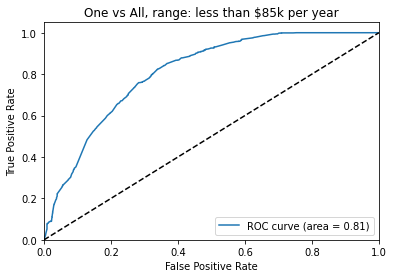

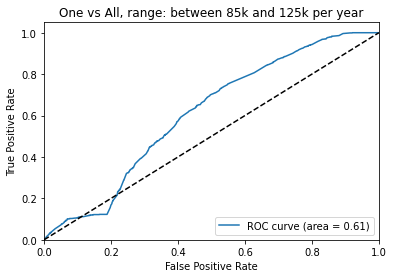

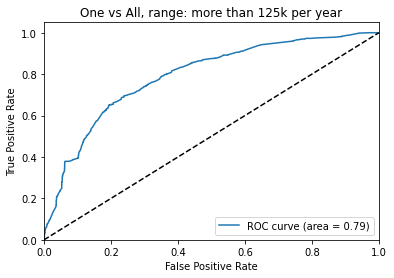

 ROC test 


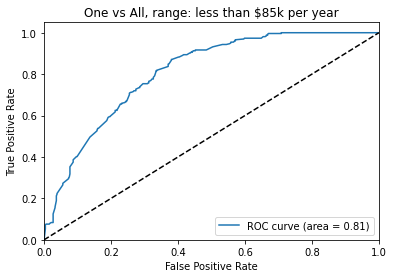

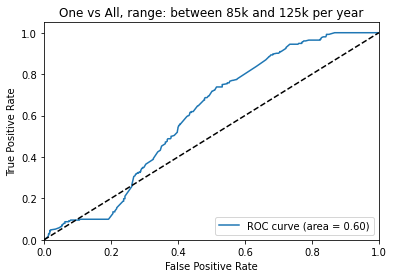

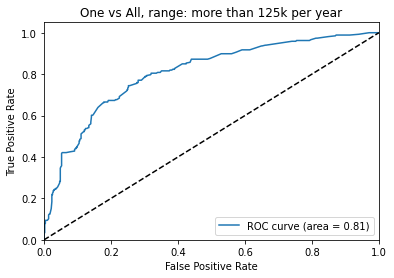

In [95]:
if 'best_ada' not in locals():
    with open('best_ada.pkl','rb') as f:
        best_ada = pickle.load(f)
mine.metrics_master_multiclass(X_train, y_train, X_test, y_test, best_ada)

### Mejores modelos:
1.- Gradiente Estocástico Descendente  
2.- Gradient Boost  
3.- Random Forest

# Pruebas de estabilidad

Para las pruebas, se urilizará la totalidad del dataset, que lo mismo que los registros de entrenamiento y de prueba.
Se debe observar un buen desempeño en la distribución de la probabilidad de predicción de cada clase.

In [96]:
X = pipeline.transform("DataScientist.csv")

### Gradient Boost

In [97]:
mine.stability_multiclass(X_train, best_gb)

less than $85k


,Prob,Other classes,less than $85k
0,"(0,0.1]",720,0
0,"(0.1,0.2]",435,0
0,"(0.2,0.3]",353,0
0,"(0.3,0.4]",314,39
0,"(0.4,0.5]",95,297
0,"(0.5,0.6]",0,367
0,"(0.6,0.7]",0,210
0,"(0.7,0.8]",0,205
0,"(0.8,0.9]",0,89
0,"(0.9,1.0]",0,3




between 85k and 125k


,Prob,Other classes,between 85k and 125k
0,"(0,0.1]",311,0
0,"(0.1,0.2]",526,0
0,"(0.2,0.3]",665,0
0,"(0.3,0.4]",602,47
0,"(0.4,0.5]",141,316
0,"(0.5,0.6]",0,281
0,"(0.6,0.7]",0,193
0,"(0.7,0.8]",0,37
0,"(0.8,0.9]",0,8
0,"(0.9,1.0]",0,0




more than 125k


,Prob,Other classes,more than 125k
0,"(0,0.1]",360,0
0,"(0.1,0.2]",999,0
0,"(0.2,0.3]",481,0
0,"(0.3,0.4]",187,38
0,"(0.4,0.5]",65,137
0,"(0.5,0.6]",0,218
0,"(0.6,0.7]",0,239
0,"(0.7,0.8]",0,167
0,"(0.8,0.9]",0,190
0,"(0.9,1.0]",0,46


### Gradiente Estocástico Descendente

In [98]:
mine.stability_multiclass(X_train, best_sgd)

less than $85k


,Prob,Other classes,less than $85k
0,"(0,0.1]",252,0
0,"(0.1,0.2]",658,0
0,"(0.2,0.3]",379,0
0,"(0.3,0.4]",405,81
0,"(0.4,0.5]",43,775
0,"(0.5,0.6]",0,304
0,"(0.6,0.7]",0,226
0,"(0.7,0.8]",0,4
0,"(0.8,0.9]",0,0
0,"(0.9,1.0]",0,0




between 85k and 125k


,Prob,Other classes,between 85k and 125k
0,"(0,0.1]",18,0
0,"(0.1,0.2]",314,0
0,"(0.2,0.3]",816,0
0,"(0.3,0.4]",1079,64
0,"(0.4,0.5]",176,613
0,"(0.5,0.6]",0,47
0,"(0.6,0.7]",0,0
0,"(0.7,0.8]",0,0
0,"(0.8,0.9]",0,0
0,"(0.9,1.0]",0,0




more than 125k


,Prob,Other classes,more than 125k
0,"(0,0.1]",32,0
0,"(0.1,0.2]",693,0
0,"(0.2,0.3]",1015,0
0,"(0.3,0.4]",339,85
0,"(0.4,0.5]",35,289
0,"(0.5,0.6]",0,326
0,"(0.6,0.7]",0,222
0,"(0.7,0.8]",0,91
0,"(0.8,0.9]",0,0
0,"(0.9,1.0]",0,0


### Random Forest

In [99]:
mine.stability_multiclass(X_train, best_random_f)

less than $85k


,Prob,Other classes,less than $85k
0,"(0,0.1]",0,0
0,"(0.1,0.2]",48,0
0,"(0.2,0.3]",829,0
0,"(0.3,0.4]",682,1133
0,"(0.4,0.5]",0,416
0,"(0.5,0.6]",0,19
0,"(0.6,0.7]",0,0
0,"(0.7,0.8]",0,0
0,"(0.8,0.9]",0,0
0,"(0.9,1.0]",0,0




between 85k and 125k


,Prob,Other classes,between 85k and 125k
0,"(0,0.1]",0,0
0,"(0.1,0.2]",0,0
0,"(0.2,0.3]",550,0
0,"(0.3,0.4]",2231,335
0,"(0.4,0.5]",0,11
0,"(0.5,0.6]",0,0
0,"(0.6,0.7]",0,0
0,"(0.7,0.8]",0,0
0,"(0.8,0.9]",0,0
0,"(0.9,1.0]",0,0




more than 125k


,Prob,Other classes,more than 125k
0,"(0,0.1]",0,0
0,"(0.1,0.2]",1,0
0,"(0.2,0.3]",1149,0
0,"(0.3,0.4]",764,561
0,"(0.4,0.5]",0,568
0,"(0.5,0.6]",0,84
0,"(0.6,0.7]",0,0
0,"(0.7,0.8]",0,0
0,"(0.8,0.9]",0,0
0,"(0.9,1.0]",0,0


In [105]:
import json

In [106]:
my_json= """
{
"Job Title":"Senior Data Scientist",
"Salary Estimate":"$111K-$181K (Glassdoor est.)",
"Job Description":"ABOUT HOPPER At Hopper, we’re on a mission to make booking travel faster, easier, and more transparent. We are leveraging the power that comes from combining massive amounts of data and machine learning to build the world’s fastest-growing travel app -- one that enables our customers to save money and travel more. With over $235M CAD in funding from leading investors in both Canada and the US, Hopper is primed to continue its path toward becoming the go-to way to book travel as the world continues its shift to mobile. Recognized as the fastest-growing travel app by Forbes and one of the world’s most innovative companies by Fast Company two years in a row, Hopper has been downloaded over 40 million times and has helped travelers plan over 100 million trips and counting. The app has received high praise in the form of mobile accolades such as the Webby Award for Best Travel App of 2019, the Google Play Award for Standout Startup of 2016 and Apple’s App Store Best of 2015. Take off with us! THE ROLE Hopper is looking for a data-savvy individual to join our team as a Data Scientist and lead data-centric product development and complex business intelligence projects within our core air travel business unit. Every day you would draw powerful insights from our real-time feed of billions of flight search results and archives of several trillion data points. To succeed at Hopper you need the talent, passion, and experience to thrive in a highly performing company. IN THIS ROLE YOU WILL: Frame and conduct complex exploratory analyses needed to deepen our understanding of Hopper users. Partner with product, business and strategy teams to leverage this user understanding for product improvements and other initiatives Use machine learning and big data tools on tremendously large and complex data sets to enhance our data-driven, personalized travel advice Conduct research into various aspects of our business and employ statistical and modeling techniques when appropriate to make recommendations to non-technical stakeholders Create advanced dashboards for product experiment tracking and business unit performance analysis using Amplitude and Tableau Find effective ways to simplify and communicate analyses to a non-technical audience. A PERFECT CANDIDATE HAS: A degree in Math, Statistics, Computer Science, Engineering or other quantitative disciplines Extremely strong analytical and problem-solving skills Proven ability to communicate complex technical work to a non-technical audience A strong passion for and extensive experience in conducting empirical research and answering hard questions with data Experience with a data visualization tool (Tableau preferred) and project analysis tool such as Amplitude Experience with relational databases and SQL, especially Hive Experience working with extremely large data sets Experience in Pandas, R, SAS or other tools appropriate for large scale data preparation and analysis Experience with data mining, machine learning, statistical modeling tools and underlying algorithms Proficiency with Unix/Linux environments BENEFITS • Well-funded and proven startup with large ambitions, competitive salary and stock options • Dynamic and entrepreneurial team where pushing limits is everyday business • 100% employer paid medical, dental, vision, disability and life insurance plans • Access to a 401k (US) or Retirement Savings Plan (Canada)",
"Rating":3.5,
"Company Name":"Hopper3.5",
"Location":"New York, NY",
"Headquarters":"Montreal, Canada",
"Size":"501 to 1000 employees",
"Founded":2007,
"Type of ownership":"Company - Private",
"Industry":"Travel Agencies",
"Sector":"Travel & Tourism",
"Revenue":"Unknown / Non-Applicable",
"Competitors":"-1",
"Easy Apply":"-1"
}
"""

In [107]:
json_data = json.loads(my_json)

In [108]:
register_df = pd.json_normalize(json_data)
register_df = register_df.replace([-1,'-1','Unknown / Non-Applicable'], np.nan)
register_df

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER At Hopper, we’re on a mission to ...",3.5,Hopper3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,NaN,NaN,NaN


In [109]:
pipeline.transform(register_df)

array([[-0.50261022,  0.61417345, -0.64266166, ..., -0.21038062,
        -0.31172894, -0.22617299]])

In [110]:
df_100 = pd.read_csv('DataScientist.csv')
df_100

,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,1,1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1
2,2,2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,True
3,3,3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1
4,4,4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"BBDO, Grey Group, Droga5",-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,3904,4375,AWS Data Engineer,$55K-$112K (Glassdoor est.),About Us\n\nTachyon Technologies is a Digital ...,4.4,Tachyon Technologies\n4.4,"Dublin, OH","Irving, TX",201 to 500 employees,2011,Company - Private,IT Services,Information Technology,$10 to $25 million (USD),-1,-1
3905,3905,4376,Data Analyst â Junior,$55K-$112K (Glassdoor est.),"Job description\nInterpret data, analyze resul...",5.0,"Staffigo Technical Services, LLC\n5.0","Columbus, OH","Woodridge, IL",51 to 200 employees,2008,Company - Private,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
3906,3906,4377,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),Job DescriptionThe Security Analytics Data Eng...,3.8,"PDS Tech, Inc.\n3.8","Dublin, OH","Irving, TX",5001 to 10000 employees,1977,Company - Private,Staffing & Outsourcing,Business Services,$100 to $500 million (USD),-1,-1
3907,3907,4378,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),The Security Analytics Data Engineer will inte...,4.0,Data Resource Technologies\n4.0,"Dublin, OH","Omaha, NE",1 to 50 employees,-1,Company - Private,Accounting,Accounting & Legal,Less than $1 million (USD),-1,-1


In [111]:
df_100.sample(100).to_csv('test_100.csv', index=False)